<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques that are used to avoid overfitting (but haven't practiced them yet). In this project, we'll practice a fundamental method for avoiding overfitting that is commonly referred to as: _train/test split validation_. 

This is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we will be splitting the data into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California, 20 percent data from elsewhere, and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case, we've still overfit on our data set because we did not sufficiently randomize the data.

Note: In a situation like this, you could use a technique called _k-fold cross-validation_, which is cross-validation applied to more than two subsets. In particular, in k-fold cross-validation, you'd partition your data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. You would do this for each of the possible $k-1$ subsets.

# Project Requirements

The goal of this project will be to create a test-training split to compare multiple models on the same Boston housing data set. For example, you might choose to compare different linear models on the same data.

In this project, you'll fit two to three different models on the Boston housing data. For example, you could pick two different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Work with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train your model on the training data.
* Evaluate your model on the test data.
* Repeat with other variables.
* Rank the models by how well they score on the testing data set. 
* Don't forget to interpret your findings! 



A k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression

As a real estate developer, you are being asked to model the median home price of various houses in the city of Boston using data from the US census. Your goal is to predict a continuous, numeric output (price) based on a combination of discrete features that you choose.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from itertools import combinations
from matplotlib.pyplot import figure

%matplotlib inline

In [2]:
#Load Boston data

boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
description = boston.DESCR
X = df.iloc[:,:-1]
y= df['MEDV'] 


print(description)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### REQUIRED: Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it _ought_ to be pretty clean, but you should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
df_exploratory = df.describe(include='all')
df_exploratory.loc['Unique'] = df.nunique()
df_exploratory.loc['Null'] = df.isna().sum()
df_exploratory.loc['dtype'] = df.dtypes

df_exploratory

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506,506,506,506,506,506,506,506,506,506,506,506,506,506
mean,3.61352,11.3636,11.1368,0.06917,0.554695,6.28463,68.5749,3.79504,9.54941,408.237,18.4555,356.674,12.6531,22.5328
std,8.60155,23.3225,6.86035,0.253994,0.115878,0.702617,28.1489,2.10571,8.70726,168.537,2.16495,91.2949,7.14106,9.1971
min,0.00632,0,0.46,0,0.385,3.561,2.9,1.1296,1,187,12.6,0.32,1.73,5
25%,0.082045,0,5.19,0,0.449,5.8855,45.025,2.10018,4,279,17.4,375.377,6.95,17.025
50%,0.25651,0,9.69,0,0.538,6.2085,77.5,3.20745,5,330,19.05,391.44,11.36,21.2
75%,3.67708,12.5,18.1,0,0.624,6.6235,94.075,5.18843,24,666,20.2,396.225,16.955,25
max,88.9762,100,27.74,1,0.871,8.78,100,12.1265,24,711,22,396.9,37.97,50
Unique,504,26,76,2,81,446,356,412,9,66,46,357,455,229
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
#Print Correlations
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


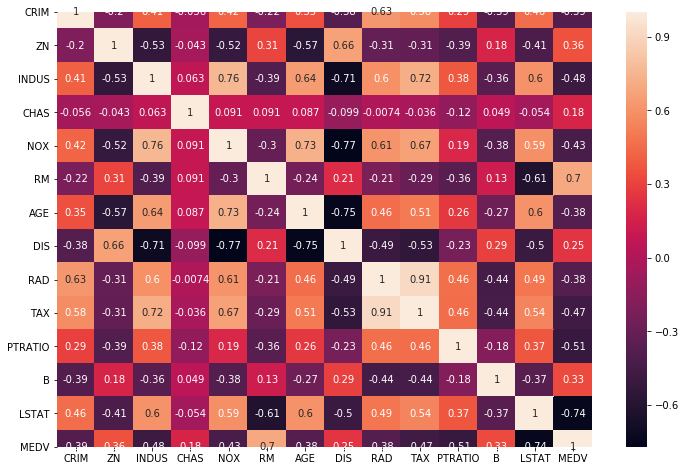

In [5]:
# Graphing correlations on heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True);

In [6]:
#Print Absolute value of correlations order by value.
absolute_value = df.corr().abs()
s = absolute_value.unstack()
so = s.sort_values(kind="quicksort")
so

CHAS   RAD      0.007368
RAD    CHAS     0.007368
CHAS   TAX      0.035587
TAX    CHAS     0.035587
ZN     CHAS     0.042697
                  ...   
CHAS   CHAS     1.000000
INDUS  INDUS    1.000000
ZN     ZN       1.000000
LSTAT  LSTAT    1.000000
MEDV   MEDV     1.000000
Length: 196, dtype: float64

## Using `scikit-learn` Linear Regression

### REQUIRED: Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict your target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [7]:
#We can get a max performance of 69.03 using only 4 columns 

In [8]:
# I didn't know which 4 columns to choose son I created scored all possible combinations to pick the highest score.

linreg = LinearRegression()
find_features = pd.DataFrame(boston.data, columns=boston.feature_names)
target_t = boston.target
scores = []

features = list(combinations(find_features,4)) #This function gets all combinations

for feats in features:
    data = df[df.columns.intersection(feats)]
    linreg.fit(data,target_t)
    rscore = linreg.score(data,target_t)
    cols_names = data.columns.values
    scores.append((data.columns.values,rscore))

def Sort(sub_list): 
    sub_list.sort(reverse = True,key = lambda x: x[1]) 
    for sc in zip(sub_list):
        print ('{}'.format(sc))
    
valores = Sort(scores)

((array(['RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype=object), 0.6903077016842538),)
((array(['RM', 'PTRATIO', 'B', 'LSTAT'], dtype=object), 0.6877467603519637),)
((array(['CHAS', 'RM', 'PTRATIO', 'LSTAT'], dtype=object), 0.6874723403557057),)
((array(['CRIM', 'RM', 'PTRATIO', 'LSTAT'], dtype=object), 0.6814923476854233),)
((array(['RM', 'AGE', 'PTRATIO', 'LSTAT'], dtype=object), 0.6801748227003213),)
((array(['RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype=object), 0.6796626444104407),)
((array(['NOX', 'RM', 'PTRATIO', 'LSTAT'], dtype=object), 0.6792050665648994),)
((array(['ZN', 'RM', 'PTRATIO', 'LSTAT'], dtype=object), 0.6789744677198571),)
((array(['RM', 'RAD', 'PTRATIO', 'LSTAT'], dtype=object), 0.6787663612113517),)
((array(['INDUS', 'RM', 'PTRATIO', 'LSTAT'], dtype=object), 0.6786434855761494),)
((array(['RM', 'DIS', 'TAX', 'LSTAT'], dtype=object), 0.6668352188792412),)
((array(['CHAS', 'RM', 'B', 'LSTAT'], dtype=object), 0.6624086155854574),)
((array(['RM', 'DIS', 'B', 'LSTAT'], dtype=objec

((array(['CRIM', 'INDUS', 'NOX', 'TAX'], dtype=object), 0.2866723753677388),)
((array(['NOX', 'AGE', 'DIS', 'TAX'], dtype=object), 0.28593648585007636),)
((array(['CHAS', 'NOX', 'AGE', 'TAX'], dtype=object), 0.28572626206976803),)
((array(['CRIM', 'CHAS', 'NOX', 'B'], dtype=object), 0.28571632774508116),)
((array(['INDUS', 'DIS', 'RAD', 'TAX'], dtype=object), 0.2851711960130101),)
((array(['CRIM', 'NOX', 'RAD', 'TAX'], dtype=object), 0.2848197779089814),)
((array(['INDUS', 'AGE', 'TAX', 'B'], dtype=object), 0.28476511752326605),)
((array(['ZN', 'INDUS', 'AGE', 'TAX'], dtype=object), 0.28470898753654783),)
((array(['CRIM', 'AGE', 'DIS', 'TAX'], dtype=object), 0.2846290029683185),)
((array(['CRIM', 'AGE', 'RAD', 'TAX'], dtype=object), 0.2845667862842143),)
((array(['ZN', 'INDUS', 'NOX', 'TAX'], dtype=object), 0.2843831713214343),)
((array(['AGE', 'DIS', 'TAX', 'B'], dtype=object), 0.2843482713347877),)
((array(['ZN', 'CHAS', 'NOX', 'B'], dtype=object), 0.28422285433637395),)
((array(['CR

In [12]:
#Getting 4 columns score.
X = df[['RM', 'DIS', 'PTRATIO', 'LSTAT']]
y = df[['MEDV']]
linreg2 = LinearRegression()
linreg2.fit(X,y)
linreg2.score(X, y)


0.6903077016842538

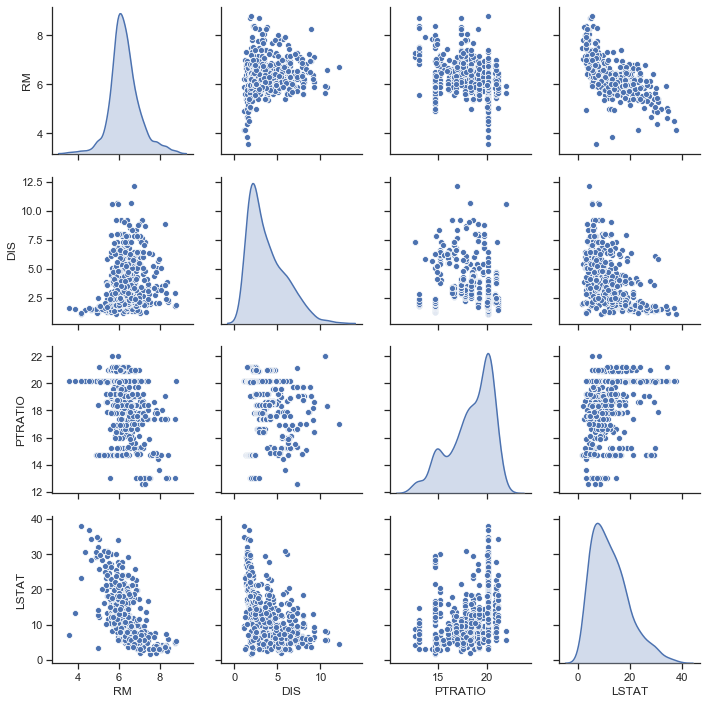

In [27]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(X, diag_kind="kde",palette="husl")

### REQUIRED: Try 70/30 and 90/10 train/test splits: 70% of the data for training - 30% for testing, then 90% for training - 10% for testing.
Score and plot both of these approaches. How do your metrics change? What does this tell us about the size of training/testing splits? Include a written response.

In [14]:
# 70-30 split has better performance than 90-30 split. Need a balance between training and test data ammount.
# I created a plot showing training data scores vs test data scores. 

In [15]:
X = df[['RM', 'DIS', 'PTRATIO', 'LSTAT']]
y = df[['MEDV']]
spsize73 = 0.3 #split for testing size 30%
spsize91 = 0.1 #split for testing size 10%

X_train70, X_test30, y_train70, y_test30 = train_test_split (X, y, test_size=spsize73, random_state=21) #splittiong 70%-30%
X_train90, X_test10, y_train90, y_test10 = train_test_split (X, y, test_size=spsize91, random_state=21)#splittiong 90%-10%


linreg73 = LinearRegression()
linreg91 = LinearRegression()

linreg73.fit(X_train70,y_train70) #fitting 70-30 Data
linreg91.fit(X_train90,y_train90) #fitting 90-10 Data

y_predict_73 = linreg73.predict(X_test30)
y_predict_91 = linreg91.predict(X_test10)

score_73 = linreg73.score(X_test30, y_test30) #scoring 70-30 Data
score_91 = linreg91.score(X_test10, y_test10) #scoring 90-10 Data


print("Prediction 70-30: \n\n",y_predict_73)
print("Prediction 90-10: ",y_predict_91)

Prediction 70-30: 

 [[18.64996552]
 [15.16575052]
 [27.06707211]
 [37.88547354]
 [29.44500708]
 [11.76059055]
 [25.87968116]
 [26.72846091]
 [31.6265187 ]
 [17.45957204]
 [22.72637918]
 [15.03758714]
 [28.05588446]
 [11.35710874]
 [18.77722302]
 [28.58386466]
 [19.97428999]
 [27.99469273]
 [ 1.81116411]
 [17.4401362 ]
 [20.25282664]
 [23.50536024]
 [19.4258375 ]
 [ 1.42222101]
 [22.33592958]
 [32.54757285]
 [24.87224864]
 [32.14929841]
 [18.97227421]
 [23.65627531]
 [25.50123867]
 [20.3457673 ]
 [31.8062331 ]
 [14.54135301]
 [29.21537079]
 [30.77185999]
 [34.79256559]
 [21.75774764]
 [22.45779127]
 [18.38826349]
 [19.77260262]
 [35.24253472]
 [24.18499496]
 [23.86835745]
 [24.19732183]
 [19.73160277]
 [28.37567161]
 [20.47749068]
 [31.65450941]
 [23.82413364]
 [31.74304489]
 [15.52501394]
 [38.1612778 ]
 [14.67223302]
 [11.85394245]
 [ 8.80298935]
 [11.18628005]
 [22.74958612]
 [21.98542211]
 [28.58219292]
 [17.59768131]
 [31.21440948]
 [25.43708644]
 [22.89038849]
 [34.62900129]
 [36

In [16]:
#Print Scores
print("Score 70-30: ", score_73, "\n")
print("Score 90-10: ", score_91)

Score 70-30:  0.6775237347934736 

Score 90-10:  0.5890691042999221


Split= 95 % - 5 % => Train Score is:= 0.6867  => Test Score is:= 0.755 => Distance=  0.0683
Split= 90 % - 10 % => Train Score is:= 0.6962  => Test Score is:= 0.5569 => Distance=  0.1393
Split= 85 % - 15 % => Train Score is:= 0.708  => Test Score is:= 0.5451 => Distance=  0.163
Split= 80 % - 20 % => Train Score is:= 0.7009  => Test Score is:= 0.6272 => Distance=  0.0737
Split= 75 % - 25 % => Train Score is:= 0.692  => Test Score is:= 0.6828 => Distance=  0.0092
Split= 70 % - 30 % => Train Score is:= 0.6973  => Test Score is:= 0.6704 => Distance=  0.0269
Split= 65 % - 35 % => Train Score is:= 0.7162  => Test Score is:= 0.6355 => Distance=  0.0807
Split= 60 % - 40 % => Train Score is:= 0.7122  => Test Score is:= 0.6482 => Distance=  0.064
Split= 55 % - 45 % => Train Score is:= 0.7025  => Test Score is:= 0.6518 => Distance=  0.0506
Split= 50 % - 50 % => Train Score is:= 0.7009  => Test Score is:= 0.6515 => Distance=  0.0494
Split= 45 % - 55 % => Train Score is:= 0.7028  => Test Score is:= 

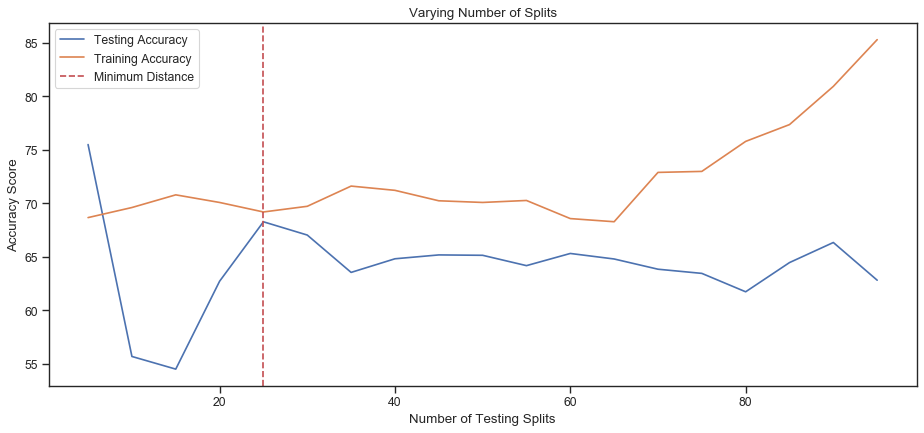

In [17]:
# Playing around....
# Creating a loop to test multiple data splits. Store score values in variable for both trining and tasting data 
# and ploting results. 


X = df[['RM', 'DIS', 'PTRATIO', 'LSTAT']]
y = df[['MEDV']]
#split_size = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
split_size = np.arange(0.05, 1, 0.05)
i=0
train_accuracy = np.empty(len(split_size))
test_accuracy = np.empty(len(split_size))
train_test_distantce = np.empty(len(split_size))

for k in split_size:
    X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=k, random_state=1987)
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    y_predict = linreg.predict(X_test)
    score = linreg.score(X_test, y_test)
    
    #Compute accuracy on the training set
    train_accuracy[i] = linreg.score(X_train,y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = linreg.score(X_test, y_test)
    
    train_test_distantce[i] = round(abs(train_accuracy[i]-test_accuracy[i]),4)
    training_d = int(round(((1-round(k,2))*100)))
    testing_d = int((round(k,2)*100))
    print ("Split=",training_d,"% -",testing_d,"% => Train Score is:=",round(train_accuracy[i],4) ," => Test Score is:=",round(test_accuracy[i],4),"=> Distance= ", round(train_test_distantce[i],4) )
    
    i=i+1

#Getting minimum distances between training/testing scores    

min_dist_line = split_size[(train_test_distantce.tolist().index(min(train_test_distantce.tolist())))]

# Generate plot
figure(figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Varying Number of Splits')
plt.plot((split_size)*100, test_accuracy*100, label = 'Testing Accuracy')
plt.plot((split_size)*100, train_accuracy*100, label = 'Training Accuracy')
plt.axvline(min_dist_line*100, color='r', linestyle='--', label = 'Minimum Distance') #Line on minimum Distance.
plt.legend()
plt.xlabel('Number of Testing Splits')
plt.ylabel('Accuracy Score')
plt.show()


## BONUS: Try the k-fold cross-validation technique described above, varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds? Include a written response.

In [18]:
# KFold - 10 Splits 
kf = KFold(n_splits=5)
splits = list(kf.split(X_train))
lr = LinearRegression()
cross_val_scores5 = []

# this will get the index values increasing stepwise from 0 to 403
X_train = X_train.reset_index()
y_train = y_train.reset_index()

# this will get rid of the 'index' column that pops up after you reset the index
X_train = X_train.drop('index', axis=1)
y_train = y_train.drop('index', axis=1)


for test_idx, val_idx in kf.split(X_train):
    lr.fit(X_train.iloc[test_idx], y_train.iloc[test_idx])
    score = lr.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
    cross_val_scores5.append(score)

cross_val_scores5

[0.8208247210158579,
 0.9403763282903153,
 -0.6356686379898542,
 0.3326453954074239,
 0.6867575405633743]

In [19]:
np.mean(cross_val_scores5)

0.4289870694574235

In [20]:
# KFold - 10 Splits 
kf = KFold(n_splits=10)
splits = list(kf.split(X_train))
lr = LinearRegression()
cross_val_scores10 = []

# this will get the index values increasing stepwise from 0 to 403
X_train = X_train.reset_index()
y_train = y_train.reset_index()

# this will get rid of the 'index' column that pops up after you reset the index
X_train = X_train.drop('index', axis=1)
y_train = y_train.drop('index', axis=1)


for test_idx, val_idx in kf.split(X_train):
    lr.fit(X_train.iloc[test_idx], y_train.iloc[test_idx])
    score = lr.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
    cross_val_scores10.append(score)
    
cross_val_scores10

[-1.3193168614402353,
 0.9720449872503768,
 0.9200751712121823,
 -4.232457435119757,
 -0.1418803949960601,
 -6.054734191130798,
 0.8315553575635016,
 0.7425731713662918,
 0.7727658765904356,
 -5.923004354497592]

In [21]:
np.mean(cross_val_scores10)

-1.3432378673201655

In [22]:
#Testing different fold values

X = df[['RM', 'DIS', 'PTRATIO', 'LSTAT']]
y = df[['MEDV']]
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=21)

In [23]:
splits_test = list(range(5,31)) #-->Created a list range from 5-30 to be used in Kfold method
lr = LinearRegression()
cross_val_scores = []
cross_val_scores_m = []

for sp in splits_test:
    kf = KFold(n_splits=sp)
    splits = list(kf.split(X_train))
    

    # this will get the index values increasing stepwise from 0 to 403
    X_train = X_train.reset_index()
    y_train = y_train.reset_index()

    # this will get rid of the 'index' column that pops up after you reset the index
    X_train = X_train.drop('index', axis=1)
    y_train = y_train.drop('index', axis=1)


    for test_idx, val_idx in kf.split(X_train):
        lr.fit(X_train.iloc[test_idx], y_train.iloc[test_idx])
        score = lr.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
        cross_val_scores.append((sp,score))

        
sc_values = pd.DataFrame(cross_val_scores, columns =['Ks','Score']) 
kscores_mean = sc_values.groupby('Ks')['Score'].mean()
print (kscores_mean.sort_values(ascending=False), "\n\n")
print ("k=",kscores_mean.idxmax(),"has the max score= ",kscores_mean.max())



Ks
10    0.680490
12    0.676873
8     0.676850
5     0.671910
9     0.667918
6     0.667698
11    0.666218
13    0.661161
7     0.659972
15    0.652856
18    0.651258
17    0.648712
16    0.646261
24    0.644155
14    0.640299
21    0.639115
19    0.637511
20    0.627952
27    0.625516
25    0.621609
23    0.605031
22    0.603298
30    0.593436
28    0.590813
26    0.457821
29    0.404235
Name: Score, dtype: float64 


k= 10 has the max score=  0.6804903669063311


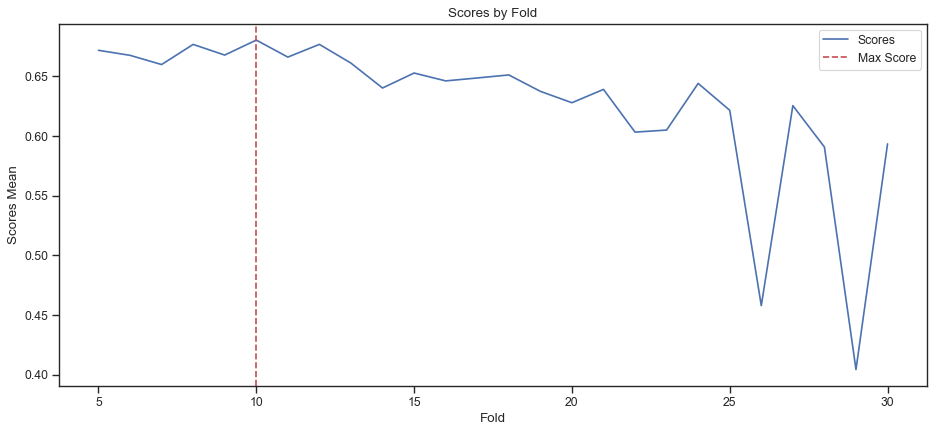

In [24]:
#Graphing Scores
figure(figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Scores by Fold')
plt.plot(splits_test, kscores_mean, label = 'Scores')
plt.axvline(kscores_mean.idxmax(), color='r', linestyle='--', label = 'Max Score') #Line on Highest score
plt.legend()
plt.xlabel('Fold')
plt.ylabel('Scores Mean')
plt.show()

## BONUS
Practice the same workflow you just worked through above, but this time use Statsmodels instead of Sklearn for linear regression. See example formulas below.

### Example: Statsmodels Formulas

Adjust the formula using your chosen metrics from the housing data. Remember, your workflow here is the same, but the syntax is a little different. Describe your results. Are they comparable to scikit-learn's regression models?

In [25]:
# First, format your data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [26]:
# Set up your new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Mon, 16 Dec 2019   Prob (F-statistic):                   1.38e-321
Time:                        18:57:33   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9729      0.224     22.195      0.000       4.533       5.413
LSTAT         -0.5606      0.048    -11.795      0.000      -0.654      -0.467
RAD            0.2128      0.070      3.050      0.002       0.076       0.350
TAX           -0.0174      0.004     -4.272      0.000      -0.025      -0.009
NOX            4.3448      3.384      1.284      0.200      -2.304      10.994
INDUS          0.0924      0.067      1.383      0.167      -0.039       0.224
CRIM          -0.0891      0.037     -2.423      0.016      -0.161      -0.017
ZN             0.0288      0.013      2.220      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.139   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.155
Skew:                           1.666   Prob(JB):                    1.99e-181
Kurtosis:                       8.326   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### BONUS:

Can you optimize your R2, selecting the best features? Provide your code and explain your process in a brief written response.

### BONUS:

Given a combination of predictors, can you identify another response variable that could be accurately predicted through the exploration of different predictors in this data set?

_Tip: Consider pairplots, coefficients, or Pearson scores._

In [10]:
# Check out variable relations
import seaborn as sns

In [ ]:
# Check out Pearson scores


## BONUS/DEMO: Up for an additional challenge? Try again, this time using the `patsy` library.

You can read more about it here: https://patsy.readthedocs.io/en/latest/

In [11]:
import patsy

# Use the patsy library to run a regression model on the housing dataset
